In [1]:
from matplotlib import pyplot as plt
from mxnet import gpu
from gluoncv import model_zoo, data, utils
import numpy as np
% matplotlib inline

import cv2
import os

In [7]:
net = model_zoo.get_model('yolo3_darknet53_voc', pretrained=True)#, ctx=gpu())

* Faster R-CNN ResNet50 takes ~15-20s per image inference on CPU
* Yolo v3 MobileNet takes < 0.5s per image inference on CPU
* Yolo v3 Darknet takes ~2-4s per image inference on CPU
* Yolo v3 Darknet takes <0.5s per image inference on GPU crazy fast

In [17]:
def detect_and_crop(images, save_path):
    for img in images:
        x, orig_img = data.transforms.presets.yolo.load_test(img, short=416, max_size=1024)
        box_ids, scores, bboxes = net(x.as_in_context(gpu()))
        try:
            xmin, ymin, xmax, ymax = get_bounding_box_coords(bboxes[0], box_ids[0], scores[0])
            save_file = os.path.join(save_path, img.split('/')[-1])
            if xmax > xmin and ymax > ymin:
                cv2.imwrite(save_file,
                            cv2.cvtColor(orig_img[ymin:ymax, xmin:xmax],
                                         cv2.COLOR_BGR2RGB))
            else:
                print('ERROR:' + img)
        except:
            print('ERROR: ' + img)
    return True

In [4]:
def get_bounding_box_coords(bbox, box_id, score):
    """Returns left, bottom, right, top."""
    try:
        bbox = bbox.asnumpy()
        box_id = box_id.asnumpy()
        score = score.asnumpy()
        
        # sort by best person scores
        best_scores = np.argsort(score[box_id == 14])[::-1]
        for i in best_scores:
            best_box = bbox[np.where(box_id == 14)[0]][i]
            xmin, ymin, xmax, ymax = tuple(int(x) for x in best_box)
            if (xmax-xmin) * (ymax-ymin) >= 10000: # skip small persons
                return tuple(int(x) for x in best_box)
        raise ValueError('No Prediction.')
    except e:
        raise ValueError('No Prediction.')
#         return [-1]

Testing code

In [8]:
imgname = '659584-Snakey-chartreuse-love-dress-black-zara-sandals.jpg'
x, orig_img = data.transforms.presets.rcnn.load_test('./images/'+imgname,
                                                     short=416, max_size=1024)
box_ids, scores, bboxes = net(x)#.as_in_context(gpu()))

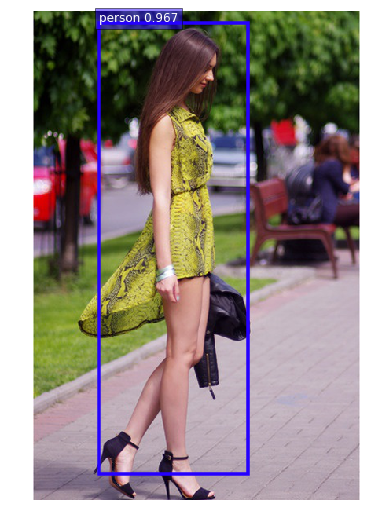

In [9]:
fig = plt.figure(figsize=(6,9))
a = plt.subplot(1,1,1)
ax = utils.viz.plot_bbox(orig_img, bboxes[0], scores[0], box_ids[0], class_names=net.classes, thresh=0.5, ax=a)
plt.axis('off')
plt.show()

In [57]:
bbox = bboxes[0].asnumpy()
box_id = box_ids[0].asnumpy()
score = scores[0].asnumpy()

In [78]:
np.argsort(score[box_id == 14])[::-1]

array([0, 1], dtype=int64)

In [84]:
bbox[np.where(box_id == 14)[0]]

array([232.45981 ,  42.441956, 377.70718 , 641.4221  ], dtype=float32)

In [86]:
get_bounding_box_coords(bboxes[0], box_ids[0], scores[0])

(232, 42, 377, 641)

In [87]:
cv2.imshow('a', cv2.cvtColor(orig_img[42:641, 232:377],
                                     cv2.COLOR_BGR2RGB))
cv2.waitKey(0)

-1

Use generator function on images

In [ ]:
root = './images/'
images = os.listdir(root)
image_filenames = [os.path.join(root, im) for im in images]

In [72]:
detect_and_crop(image_filenames, './cropped/')

ERROR: ./images/1003546-Bitter+Sweet+Symphony-cats-print-choies-dress.jpg
ERROR: ./images/1006765-The+Other+Woman-gray-moikana-dress.jpg
ERROR: ./images/1007532-Ada+Zanditon+21st+Century+Couture-ada-zanditon-dress.jpg
ERROR: ./images/1011436-Salut+ma+ch%C3%A9rie-red-maxi-bershka-dress.jpg
ERROR: ./images/1012317-Spring+Floral-brown-button-down-old-navy-cardigan-gray-floral-print-club-monaco-dress.jpg
ERROR: ./images/1015278-Dainty+Rascal-white-patterned-dainty-rascal-dress-light-brown-scallop-poetic-license-heels.jpg
ERROR: ./images/1019915-Blue+Peplum-navy-peplum-dresslily-dress-black-gucci-sunglasses.jpg
ERROR: ./images/1020037-A+vintage+afternoon-ivory-vintage-gloves-ivory-lily-j-london-dress.jpg
ERROR: ./images/1025650-Black+Yellow-ciriana-dress-tommy-hilfiger-bag.jpg
ERROR: ./images/1027105-Hawaiian+Maxi-burnt-orange-vintage-nordstrom-sunglasses-teal-vintage-maxi-hilo-hattie-dress.jpg
ERROR: ./images/1027432-always+gold-handmade-dress.jpg
ERROR: ./images/1034076-day+at+the+beach-h

True

Retry on error images, including images that did not crop properly.

In [5]:
errors = """
ERROR: ./images/1003546-Bitter+Sweet+Symphony-cats-print-choies-dress.jpg
ERROR: ./images/1006765-The+Other+Woman-gray-moikana-dress.jpg
ERROR: ./images/1007532-Ada+Zanditon+21st+Century+Couture-ada-zanditon-dress.jpg
ERROR: ./images/1011436-Salut+ma+ch%C3%A9rie-red-maxi-bershka-dress.jpg
ERROR: ./images/1012317-Spring+Floral-brown-button-down-old-navy-cardigan-gray-floral-print-club-monaco-dress.jpg
ERROR: ./images/1015278-Dainty+Rascal-white-patterned-dainty-rascal-dress-light-brown-scallop-poetic-license-heels.jpg
ERROR: ./images/1019915-Blue+Peplum-navy-peplum-dresslily-dress-black-gucci-sunglasses.jpg
ERROR: ./images/1020037-A+vintage+afternoon-ivory-vintage-gloves-ivory-lily-j-london-dress.jpg
ERROR: ./images/1025650-Black+Yellow-ciriana-dress-tommy-hilfiger-bag.jpg
ERROR: ./images/1027105-Hawaiian+Maxi-burnt-orange-vintage-nordstrom-sunglasses-teal-vintage-maxi-hilo-hattie-dress.jpg
ERROR: ./images/1027432-always+gold-handmade-dress.jpg
ERROR: ./images/1034076-day+at+the+beach-hat-floppy-hat-ducks-in-a-row-hat-slip-free-people-dress.jpg
ERROR: ./images/1036295-Wanted+Dead+Or+Alive-black-dress-black-h-m-hat-black-bag.jpg
ERROR: ./images/1037614-palm+dress+on+an+island-vintage-shoes-vintage-dress.jpg
ERROR: ./images/1041605-Boyfriend+Jeans-asos-boots-asos-dress-asos-jeans-asos-sweater-topshop-bag.jpg
ERROR: ./images/1043309-Vintage+Floral+Dress-black-vintage-dress-black-dsw-heels.jpg
ERROR: ./images/1043427-Blue+Marine-dkny-watch-topshop-shoes-zara-dress-a%C3%AFta-bag-miu-miu-sunglasses.jpg
ERROR: ./images/1056821-Every+Summer+Has+a+Story+18-black-new-look-dress.jpg
ERROR: ./images/1058561-About+A+Dress-light-pink-reformation-dress-black-miu-miu-heels.jpg
ERROR: ./images/1058633-Floral+kimono-black-doll-poup%C3%A9e-jacket-ivory-molly-bracken-dress.jpg
ERROR: ./images/1058645-TAKE+ME+TO+THE+PARADISE-carrot-orange-straw-centro-bag-carrot-orange-palm-print-sheinside-dress.jpg
ERROR: ./images/1060812-Never+More-camel-boots-ivory-thrifted-vintage-dress.jpg
ERROR: ./images/1069259-FLORAL+MAXI-floral-maxi-missguided-dress.jpg
ERROR: ./images/1077494-SIENNA+MAXI-maxi-missguided-dress.jpg
ERROR: ./images/1077983-Christian+Dior-christian-dior-dress-christian-dior-bag.jpg
ERROR: ./images/1078286-Out+of+the+Blues-turquoise-blue-displicent-dress.jpg
ERROR: ./images/1078562-Rainbow+Cats-white-depurtat-shoes-white-outliers-dress-black-new-look-jacket.jpg
ERROR: ./images/1078680-Gray+cardigan-charcoal-gray-mango-cardigan-black-stradivarius-boots.jpg
ERROR: ./images/1099163-nyfw+day+1-salmon-missguided-dress.jpg
ERROR: ./images/1100752-KALEIDOSCOPIC-pizza-groundscore-nyc-ring-geometric-print-talulah-dress.jpg
ERROR: ./images/1106318-Songbird-black-silk-alexander-wang-dress.jpg
ERROR: ./images/1111599-easy+breezy-sky-blue-denim-jacket-levis-jacket-peach-floral-maxi-bb-dakota-dress.jpg
ERROR: ./images/1120454-Peacock+Blue-blue-molly-bracken-dress-tawny-air-step-boots-tawny-the-boho-bazaar-bag.jpg
ERROR: ./images/1122851-an+oldie+but+a+goodie-vintage-dress.jpg
ERROR: ./images/1124580-PARIS-dress.jpg
ERROR: ./images/1128772-Listen+to+the+voice+inside-new-dress-dress.jpg
ERROR: ./images/1131018-Unpredictable-grecian-dress.jpg
ERROR: ./images/1134245-Disclosure-allhqfashion-shoes-poppy-lovers-dress.jpg
ERROR: ./images/1134552-Madonna+Inn%E2%80%99s+fairy+tale-ivory-free-people-dress-tan-free-people-sandals.jpg
ERROR: ./images/1146678-Fabulous+Holiday+Dresses+Under+$50-tawny-sequined-charlotte-russe-dress.jpg
ERROR: ./images/1149571-Happy+Place-white-fringe-chevron-minkpink-cardigan.jpg
ERROR: ./images/1156517-Red+Light+White+Veil-red-lace-banggood-dress-white-tulle-banggood-hair-accessory.jpg
ERROR: ./images/1156898-Sitting+Pretty-black-bangles-saks-fifth-avenue-bracelet-neutral-ombre-alyssa-nicole-dress.jpg
ERROR: ./images/1158003-Majestic-teal-maxi-dress-roora-dress.jpg
ERROR: ./images/1158045-Ombr%C3%A9-black-black-steve-madden-boots-maroon-ombre-dealsale-dress.jpg
ERROR: ./images/1158805-A+new+life+on+the+road-burnt-orange-filippo-catarzi-hat-white-spell-designs-dress.jpg
ERROR: ./images/1160031-Adventures+On+The+Water-crimson-hot-miami-styles-dress.jpg
ERROR: ./images/1161161-White+in+the+Water-white-solace-london-dress.jpg
ERROR: ./images/1161832-Fire+Ice-ktrcollection-dress.jpg
ERROR: ./images/1167536-Bal+National-amiclubwear-dress.jpg
ERROR: ./images/1171392-Gamiss+dress-light-pink-pleated-gamiss-dress-light-pink-suede-gamiss-shoes.jpg
ERROR: ./images/1172621-Floating+Flowers-ruby-red-red-accessorize-belt-silver-grey-zaful-dress.jpg
ERROR: ./images/1179627-DVF+Harley+Davidson-bronze-silk-dvf-dress-silver-tiara-diy-hair-accessory-silver-zara-heels.jpg
ERROR: ./images/1201183-Once+Upon+A+Time+in+Caucasia+10-white-romwecom-dress.jpg
ERROR: ./images/710119-Lace+On+My+Back-urban-dressing-dress.jpg
ERROR: ./images/781386-Wet+Weather+Weekend-h-m-hat-hunter-boots-marni-for-h-m-dress-unknown-brand-jacket.jpg
ERROR: ./images/786789-Bold+And+Bright-style-eternal-dress.jpg
ERROR: ./images/905276-LEATHER+HATS+PRINTED+DRESSES-black-leather-target-hat-black-shoes-red-guess-dress-yellow-kate-spade-bag.jpg
ERROR: ./images/915841-Florals+wooden+swings-the-ramp-dress-forever-21-wedges.jpg
ERROR: ./images/946474-amethyst-light-purple-alice-mccall-dress-lime-green-k-is-for-kani-hair-accessory.jpg
ERROR: ./images/946752-autumn+leaves-black-overknee-vintage-boots-charcoal-gray-wool-mango-dress.jpg
ERROR: ./images/948550-Look+du+jour+sweet+salvation-moikana-dress.jpg
ERROR: ./images/949520-This+Is+A+Part+Of+Me+That+You+Can+Never+Take+Away+From+Me-gray-celine-bag-heather-gray-tyler-dress-silver-s-h-heels.jpg
ERROR: ./images/971407-Christmas+Dinner+Party-black-black-maia-ratiu-dress-silver-silver-charline-de-luca-heels.jpg
ERROR: ./images/976085-Red+dress-brick-red-ecugo-dress-aquamarine-h-m-scarf.jpg
ERROR: ./images/983399-FUR+FOR+SUMMER+TIME+PLEASE-fox-fur-kopenhagen-fur-dress.jpg
ERROR: ./images/987603-Sequins+dress-sequins-elens-dress.jpg"""

In [6]:
errors = [x[7:] for x in errors.split('\n')[1:]]
empty = list(filter(lambda x: os.path.getsize('./cropped/' + x) < 5000, os.listdir('./cropped/')))
empty = list(map(lambda x: './images/' + x, empty))
retry = errors + empty

In [8]:
xs, orig_imgs = data.transforms.presets.yolo.load_test(retry, short=416, max_size=1024)

In [30]:
results = [net(v.as_in_context(gpu())) for v in xs] # box_ids, scores, bboxes

In [33]:
coords = [get_bounding_box_coords(bbox[0], box_id[0], score[0])
          for (box_id, score, bbox) in results]

In [18]:
detect_and_crop(retry, './cropped/')

ERROR: ./images/1037614-palm+dress+on+an+island-vintage-shoes-vintage-dress.jpg
ERROR: ./images/1099163-nyfw+day+1-salmon-missguided-dress.jpg
ERROR: ./images/1122851-an+oldie+but+a+goodie-vintage-dress.jpg
ERROR: ./images/1161832-Fire+Ice-ktrcollection-dress.jpg
ERROR: ./images/1201183-Once+Upon+A+Time+in+Caucasia+10-white-romwecom-dress.jpg
ERROR: ./images/1199478-Once+Upon+A+Time+in+Caucasia-bubble-gum-christian-dior-dress.jpg
ERROR: ./images/1201183-Once+Upon+A+Time+in+Caucasia+10-white-romwecom-dress.jpg


True

In [20]:
# still have bad predictions ~350 of them
empty = list(filter(lambda x: os.path.getsize('./cropped/' + x) < 5500, os.listdir('./cropped/')))
for f in empty:
    os.remove('./cropped/' + f)

One more try with Faster R-CNN

In [19]:
empty = list(filter(lambda x: os.path.getsize('./cropped/' + x) < 5500, os.listdir('./cropped/')))
empty = list(map(lambda x: './images/' + x, empty))

In [14]:
x, orig_img = data.transforms.presets.yolo.load_test(empty[0], short=416, max_size=1024)

In [11]:
results = [net(v.as_in_context(gpu())) for v in xs] # box_ids, scores, bboxes

In [47]:
coords = [get_bounding_box_coords(bbox[0], box_id[0], score[0]) for (box_id, score, bbox) in results]

In [ ]:
box_ids, scores, bboxes = net(x.as_in_context(gpu()))

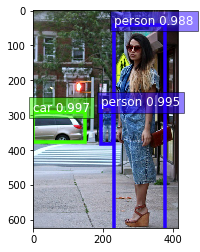

In [33]:
ax = utils.viz.plot_bbox(orig_img, bboxes[0], scores[0], box_ids[0], class_names=net.classes, thresh=0.5)
plt.show()

In [16]:
get_bounding_box_coords(bboxes[0], box_ids[0], scores[0])

[-1]

In [17]:
bbox, box_id, score = bboxes[0].asnumpy(), box_ids[0].asnumpy(), scores[0].asnumpy()

In [20]:
best = np.max(score[box_id == 14])

In [25]:
np.where(score == best)[0][0]

0

In [42]:
bbox[np.where(box_id.flat == 14)][0]

array([167.5285  ,  -3.969513, 368.70435 , 569.98364 ], dtype=float32)

In [54]:
bboxes[0].asnumpy()[np.argwhere(box_ids[0].asnumpy() == 14), :]

array([[[158.03279 ,  16.015594, 378.26318 , 578.5172  ],
        [ -1.      ,  -1.      ,  -1.      ,  -1.      ]],

       [[ 35.54892 ,  85.489136, 248.90802 , 555.9355  ],
        [ -1.      ,  -1.      ,  -1.      ,  -1.      ]]], dtype=float32)

In [ ]:
best_box = bbox[best_score]
return tuple(int(x) for x in best_box)

Instantiate all images in memory, very slow due to RAM fully used.

In [ ]:
xs, orig_imgs = data.transforms.presets.yolo.load_test(image_filenames,
                                                       short=416, max_size=1024)

In [6]:
results = [net(v.as_in_context(gpu())) for v in xs] # box_ids, scores, bboxes

In [18]:
coords = [get_bounding_box_coords(bbox[0], box_id[0], score[0]) for (box_id, score, bbox) in results]

In [40]:
get_bounding_box_coords(bboxes[0], box_ids[0], scores[0])

[(127, 53, 268, 625)]

Single image test

In [22]:
x, orig_img = data.transforms.presets.yolo.load_test('./images/1000604-Front+Twist-mango-blazer-asos-dress-mango-bag-sportsgirl-necklace-asos-heels.jpg',
                                                     short=416, max_size=1024)

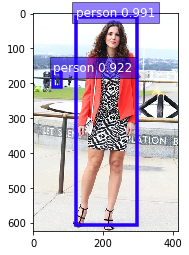

In [23]:
box_ids, scores, bboxes = net(x.as_in_context(gpu()))
ax = utils.viz.plot_bbox(orig_img, bboxes[0], scores[0], box_ids[0], class_names=net.classes, thresh=0.8)
plt.show()

In [43]:
xmin, ymin, xmax, ymax = get_bounding_box_coords(bboxes[0], box_ids[0], scores[0])